In [15]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 1.7 MB 55.1 MB/s 
     |████████████████████████████████| 438 kB 67.4 MB/s 
     |████████████████████████████████| 5.9 MB 55.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [4]:
from zipfile import ZipFile
import glob
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomBrightness
# from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler

In [5]:
tf.__version__

'2.10.0'

In [6]:
# Testing to ensure GPU is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [16]:
dataset_zip_path = "/gdrive/MyDrive/temp/NUS-ISS Workshops & Exercises/Frames_Dataset_v2.zip"

with ZipFile(dataset_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping Frames_Dataset_v2.zip')

Done unzipping Frames_Dataset_v2.zip


In [17]:
ann_dhme = "drowsiness"    # drowsiness, head, mouth or eye
num_classes = 2

batch_size = 32    # bacth size of 64 overloads the RAM after only 7-8 epochs of training
img_height = 480
img_width = 640

In [18]:
train_dataset_path = f"/content/Frames_Dataset_v2/train/{ann_dhme}"
train_dataset_path = pathlib.Path(train_dataset_path)
train_dataset_path

PosixPath('/content/Frames_Dataset_v2/train/drowsiness')

In [19]:
image_count = len(list(train_dataset_path.glob("*/*.jpg")))
print(image_count)

4808


In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dataset_path,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size
                                                       )

Found 4808 files belonging to 2 classes.
Using 3847 files for training.


In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(train_dataset_path,
                                                     validation_split=0.2,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size
                                                     )

Found 4808 files belonging to 2 classes.
Using 961 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['0', '1']


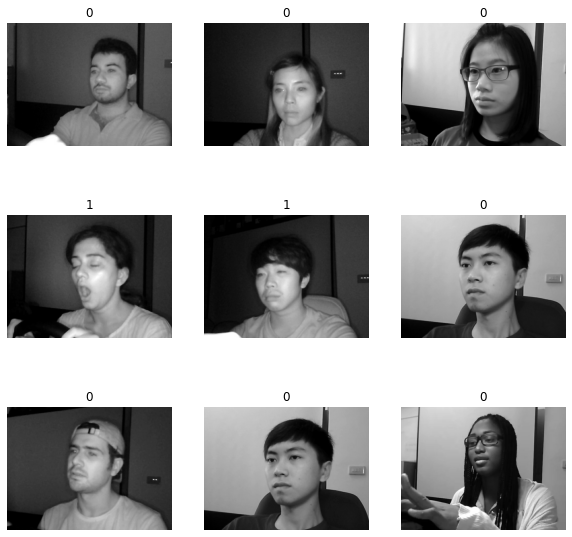

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [24]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 480, 640, 3)
(32,)


In [25]:
img_resized = 240

def preprocess_images(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [img_resized, img_resized])
    image = tf.image.rgb_to_grayscale(image)
    image = (image / 255.0)
    return image, label

In [26]:
train_ds = train_ds.map(preprocess_images)
val_ds = val_ds.map(preprocess_images)

In [27]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 240, 240, 1)
(32,)


In [48]:
modelname = f"{ann_dhme}_v1"
base_learning_rate = 0.0001
def create_model():

    # Inp = Input(shape=(img_height, img_width, 1), name='Input')
    Inp = Input(shape=(img_resized, img_resized, 1), name='Input')
    x = RandomFlip("horizontal")(Inp)
    x = RandomBrightness(0.3, value_range=(0., 1.))(x)
    x = RandomRotation(0.2)(x)

    x = Conv2D(8, (2, 2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = Dropout(0.5)(x)
    x = Conv2D(32, (2, 2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = Dropout(0.5)(x)
    x = Conv2D(128, (2, 2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(32, (2, 2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(16, (2, 2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = Dropout(0.5)(x)
    # x = Conv2D(8, (2, 2), padding='same', activation='relu')(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    # x = Dropout(0.5)(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)

    model = Model(inputs=Inp, outputs=x)

    model.compile(# loss='categorical_crossentropy',
                  # loss='binary_crossentropy',
                  loss='sparse_categorical_crossentropy',
                  # optimizer='adam',
                  # optimizer=tf.keras.optimizers.Adam(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 240, 240, 1)]     0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 240, 240, 1)       0         
                                                                 
 random_brightness_5 (Random  (None, 240, 240, 1)      0         
 Brightness)                                                     
                                                                 
 random_rotation_5 (RandomRo  (None, 240, 240, 1)      0         
 tation)                                                         
                                                                 
 conv2d_25 (Conv2D)          (None, 240, 240, 8)       40        
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 120, 120, 8)      0   

In [49]:
def lrSchedule(epoch):
    lr = 1e-3
    if epoch > 150:
        lr *= 0.5e-3
    elif epoch > 90:
        lr *= 1e-3
    elif epoch > 60:
        lr *= 1e-2
    elif epoch > 30:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [50]:
folderpath = ''
filepath = folderpath + modelname + ".hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             verbose=0,
                             save_best_only=True,
                             mode='max'
                             )

csv_logger = CSVLogger(folderpath+modelname +'.csv')

LRScheduler = LearningRateScheduler(lrSchedule)

callbacks_list = [checkpoint, csv_logger]#, LRScheduler]

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: drowsiness_v1.hdf5
Path to log:   drowsiness_v1.csv


In [51]:
epochs = 40

model_history = model.fit(train_ds,
                          validation_data=val_ds,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          callbacks=callbacks_list
                          )

Epoch 1/40


121/121 [==============================] - 38s 282ms/step - loss: 5.8587 - accuracy: 0.5560 - val_loss: 4.9179 - val_accuracy: 0.5494
Epoch 2/40
121/121 [==============================] - 34s 278ms/step - loss: 4.2129 - accuracy: 0.5675 - val_loss: 3.5816 - val_accuracy: 0.5494
Epoch 3/40
121/121 [==============================] - 35s 277ms/step - loss: 3.1040 - accuracy: 0.5682 - val_loss: 2.6731 - val_accuracy: 0.5494
Epoch 4/40
121/121 [==============================] - 34s 276ms/step - loss: 2.3458 - accuracy: 0.5727 - val_loss: 2.0533 - val_accuracy: 0.5494
Epoch 5/40
121/121 [==============================] - 32s 262ms/step - loss: 1.8304 - accuracy: 0.5695 - val_loss: 1.6344 - val_accuracy: 0.5494
Epoch 6/40
121/121 [==============================] - 33s 266ms/step - loss: 1.4826 - accuracy: 0.5711 - val_loss: 1.3514 - val_accuracy: 0.5494
Epoch 7/40
121/121 [==============================] - 33s 263ms/step - loss: 1.2475 - accuracy: 0.5719 - val_loss: 1.1600 - val_accuracy: 0.5

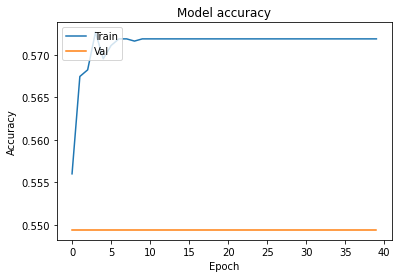

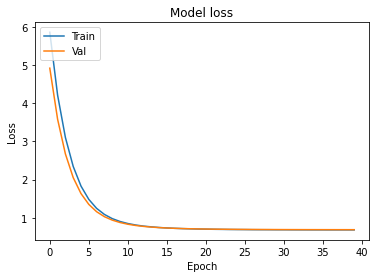

In [54]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
tf.saved_model.save(model, "test_model/")

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("test_model/") # path to the SavedModel directory
tflite_model = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)